## Calculate the lifetime of airfilter based on PM10 data

### Imports

In [83]:
import pyspark 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import StructType
from pyspark.sql.functions import *
from datetime import datetime
from datetime import timedelta
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
# for covariance
from numpy import cov
# for correlation
from scipy.stats import pearsonr
from scipy.stats import skew
import scipy.stats as stats
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline
plt.style.use('seaborn')
import scipy.stats as st

### Local variables

In [35]:
spark = SparkSession.builder\
	.master("local").appName("bde").getOrCreate()

# mean time to failure as per manufacturer spec, with expected average of 10 parts per million for dust / pm10
mttf=2500
rpm10=10
expected_days=int(mttf/24)
# airfilter installation date -- needs to be input variable?
airfilterdate='2022-03-01 00:00:00'
afdate=datetime.strptime(airfilterdate,"%Y-%m-%d %H:%M:%S")
afdate=afdate + timedelta(days=expected_days)

installdate=datetime.strptime(airfilterdate,"%Y-%m-%d %H:%M:%S").strftime('%Y-%m-%d')

print('New airfilter installed on ' + str(installdate) + ', estimated date of expiration ' + str(afdate.strftime('%Y-%m-%d')))

hdfs_host = ""
hdfs_port = ""
#file path should start with file:///
file_path = "file:///"

New airfilter installed on 2022-03-01, estimated date of expiration 2022-06-13


### Reading air quality sensor data and saving to HDFS

In [40]:
schema = StructType() \
                        .add("timestamp","timestamp") \
                        .add("entryid","integer") \
                        .add("PM1_0","double") \
                        .add("PM2_5","double") \
                        .add("PM10","double") \
                        .add("UptimeMinutes","integer") \
                        .add("RSSI_dbm","integer") \
                        .add("Temperature_F","integer") \
                        .add("Humidity_pct","integer") \
                        .add("PM2_5_ATM","double")

df = spark.read.csv(f"{file_path}/ElsiesRiver09_01_2021_05_31_2022.csv", header=False, schema=schema)
df.write.csv(f"hdfs://{hdfs_host}:{hdfs_port}/airquality/ElsiesRiver09_01_2021_05_31_2022.csv")
df = df.orderBy(col("PM10").desc())
df.show(10)

+-------------------+-------+------+-------+-------+-------------+--------+-------------+------------+---------+
|          timestamp|entryid| PM1_0|  PM2_5|   PM10|UptimeMinutes|RSSI_dbm|Temperature_F|Humidity_pct|PM2_5_ATM|
+-------------------+-------+------+-------+-------+-------------+--------+-------------+------------+---------+
|2021-10-07 09:31:55| 180296| 228.5|1062.87|1631.84|        13102|     -71|           80|          36|   708.48|
|2021-10-06 17:52:33| 179844|389.88|1090.31|1299.96|        12163|     -71|           74|          47|   726.12|
|2021-10-07 09:33:55| 180297|167.26| 690.34| 924.84|        13104|     -73|           80|          36|   461.59|
|2021-10-06 17:50:34| 179843| 49.98|  413.9| 739.47|        12161|     -71|           74|          47|   280.36|
|2021-09-01 20:07:23| 167470|311.45| 606.26| 700.18|        15010|     -78|           58|          58|    403.5|
|2021-09-01 20:25:24| 167479|389.64| 641.07| 699.33|        15028|     -77|           57|       

### Reading accelerometer sensor data and saving to HDFS

In [68]:
df = spark.read.text(f"{file_path}/logstash.log")
df2=df.withColumn("tstamp", substring(col('value'),1,25)) \
                    .withColumn("c1", split(col('value'),' ')[3]) \
                    .withColumn("c2", split(col('value'),' ')[4]) \
                    .withColumn("c3", split(col('value'),' ')[5]) 
df2=df2.withColumn("co1", regexp_replace(col('c1'),",",'')) \
                    .withColumn("co2", regexp_replace("c2",",",'')) \
                    .withColumn("co3", regexp_replace("c3",",",'')) 
df2=df2.select("tstamp",substring("co1",2,5).alias("x"),col("co2").alias("y"),split(col('co3'),']')[0].alias("z")) 
df2.write.text(f"hdfs://{hdfs_host}:{hdfs_port}/logstash.log")
df2.show(truncate=False)

+-------------------------+-----+-----+-----+
|tstamp                   |x    |y    |z    |
+-------------------------+-----+-----+-----+
|2022-06-03T08:58:05.527Z |0.396|0.098|9.77 |
|2022-06-03T08:58:07.111Z |0.405|0.079|9.771|
|2022-06-03T08:58:08.695Z |0.404|0.073|9.778|
|2022-06-03T08:58:10.281Z |0.406|0.077|9.778|
|2022-06-03T08:58:11.883Z |0.405|0.093|9.772|
|2022-06-03T08:58:13.447Z |0.394|0.085|9.762|
|2022-06-03T08:58:05.594Z |0.404|0.063|9.762|
|2022-06-03T08:58:07.180Z |0.404|0.064|9.782|
|2022-06-03T08:58:08.761Z |0.398|0.083|9.758|
|2022-06-03T08:58:10.345Z |0.405|0.091|9.767|
|2022-06-03T08:58:11.929Z |0.41 |0.076|9.772|
|2022-06-03T08:58:13.513Z |0.41 |0.085|9.765|
|2022-06-03T08:58:04.867Z |0.39 |0.061|9.792|
|2022-06-03T08:58:06.451Z |0.408|0.068|9.772|
|2022-06-03T08:58:08.035Z |0.404|0.069|9.765|
|2022-06-03T08:58:09.634Z |0.404|0.091|9.762|
|2022-06-03T08:58:11.203Z |0.397|0.084|9.769|
|2022-06-03T08:58:12.788Z |0.405|0.093|9.766|
|2022-06-03T08:58:05.725Z |0.404|0

### Reading air quality data from HDFS

In [17]:
aqdata1 = spark.read.format("csv") \
                    .option("header", True) \
                    .option("inferSchema", True) \
                    .load(f"hdfs://{hdfs_host}:{hdfs_port}/airquality/ElsiesRiver09_01_2021_05_31_2022.csv", schema=schema)

### Reading accelerometer sensor data from HDFS

In [ ]:
df = spark.read.text(f'hdfs://{hdfs_host}:{hdfs_port}/logstash.log')

df2=df.withColumn("tstamp", substring(col('value'),1,25)) \
                    .withColumn("c1", split(col('value'),' ')[3]) \
                    .withColumn("c2", split(col('value'),' ')[4]) \
                    .withColumn("c3", split(col('value'),' ')[5]) 
df2=df2.withColumn("co1", regexp_replace(col('c1'),",",'')) \
                    .withColumn("co2", regexp_replace("c2",",",'')) \
                    .withColumn("co3", regexp_replace("c3",",",'')) 
df2=df2.select("tstamp",substring("co1",2,5).alias("x"),col("co2").alias("y"),split(col('co3'),']')[0].alias("z"))       
df3.show(truncate=False)

### Only keeping data after the airfilter was installed

In [23]:
aqdata=df.where(aqdata1.timestamp > airfilterdate)

### Simple calculations to understand the data

In [98]:
# for testing
pmmindate=aqdata.select(min("timestamp"))
pmmaxdate=aqdata.select(max("timestamp"))
pm10total=aqdata.select(sum("PM10"))
pmperiod=aqdata.select(datediff(max("timestamp"),min("timestamp")))
pmcount=aqdata.select(count("timestamp").alias("pmcount"))
pm10total.show()     
pmperiod.show()
pmcount.show()
pmmindate.show()
pmmaxdate.show()

+------------------+
|         sum(PM10)|
+------------------+
|1089342.8700000003|
+------------------+

+----------------------------------------+
|datediff(max(timestamp), min(timestamp))|
+----------------------------------------+
|                                      91|
+----------------------------------------+

+-------+
|pmcount|
+-------+
|  64867|
+-------+

+-------------------+
|     min(timestamp)|
+-------------------+
|2022-03-01 00:01:53|
+-------------------+

+-------------------+
|     max(timestamp)|
+-------------------+
|2022-05-31 20:11:06|
+-------------------+



### Descriptive analysis

In [84]:
data = aqdata.toPandas()
data.describe()

,entryid,PM1_0,PM2_5,PM10,UptimeMinutes,RSSI_dbm,Temperature_F,Humidity_pct,PM2_5_ATM
count,64867.000000,64867.000000,64867.000000,64867.000000,64867.000000,64867.000000,64867.000000,64867.000000,64867.000000
mean,306603.000000,10.740903,15.437625,16.793483,15070.520002,-52.734102,69.748932,54.551189,13.571553
std,18725.634293,16.187133,22.334197,23.790049,10456.594386,3.099322,6.998711,12.392376,16.036949
min,274170.000000,0.000000,0.000000,0.000000,1.000000,-67.000000,47.000000,9.000000,0.000000
25%,290386.500000,2.030000,3.490000,4.100000,5761.000000,-55.000000,65.000000,47.000000,3.490000
50%,306603.000000,5.100000,7.720000,8.680000,13218.000000,-52.000000,69.000000,56.000000,7.720000
75%,322819.500000,12.195000,17.490000,19.010000,24029.000000,-50.000000,74.000000,64.000000,17.470000
max,339036.000000,216.460000,399.440000,494.910000,37297.000000,-44.000000,94.000000,78.000000,265.650000


### Density plot

C:\Users\lenovo\anaconda3\envs\pyspark\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lenovo\anaconda3\envs\pyspark\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Density plot of the Temperature_F and Humidity_%.')

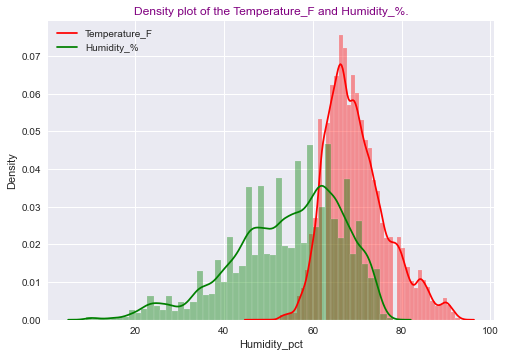

In [88]:
sns.distplot(data["Temperature_F"], color="red")
sns.distplot(data["Humidity_pct"], color="green")
plt.legend(['Temperature_F', 'Humidity_%'], loc='upper left')
plt.title("Density plot of the Temperature_F and Humidity_%.", color="purple")

### Correlation plot

<AxesSubplot:title={'center':'CORRELATION PLOT'}>

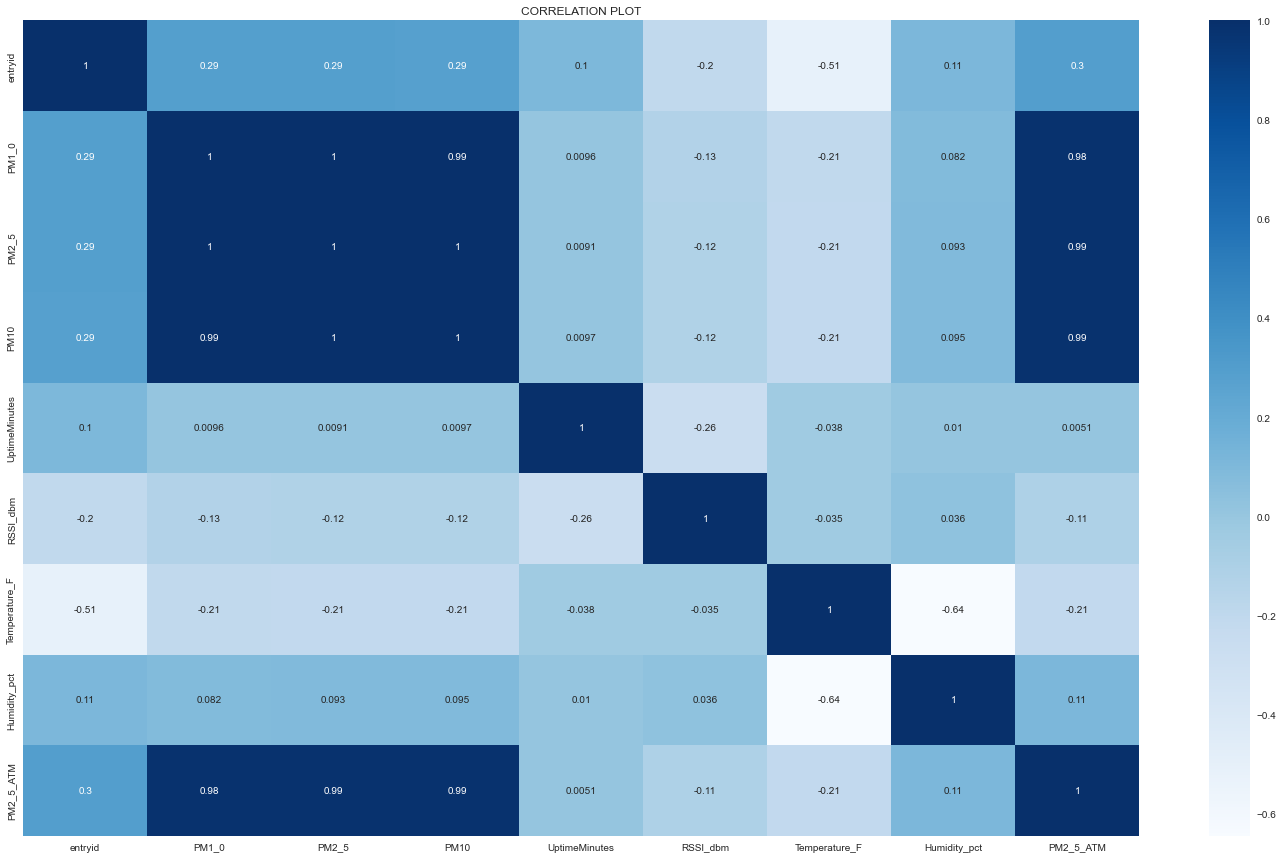

In [100]:
plt.title('CORRELATION PLOT')
plt.rcParams['figure.figsize'] = (15, 15)
sns.heatmap(data.corr(), annot= True, cmap = 'Blues', fmt='.2g')

### Air quality sensor data analysis

Actual date of expiration is predicted to be 2022-05-14


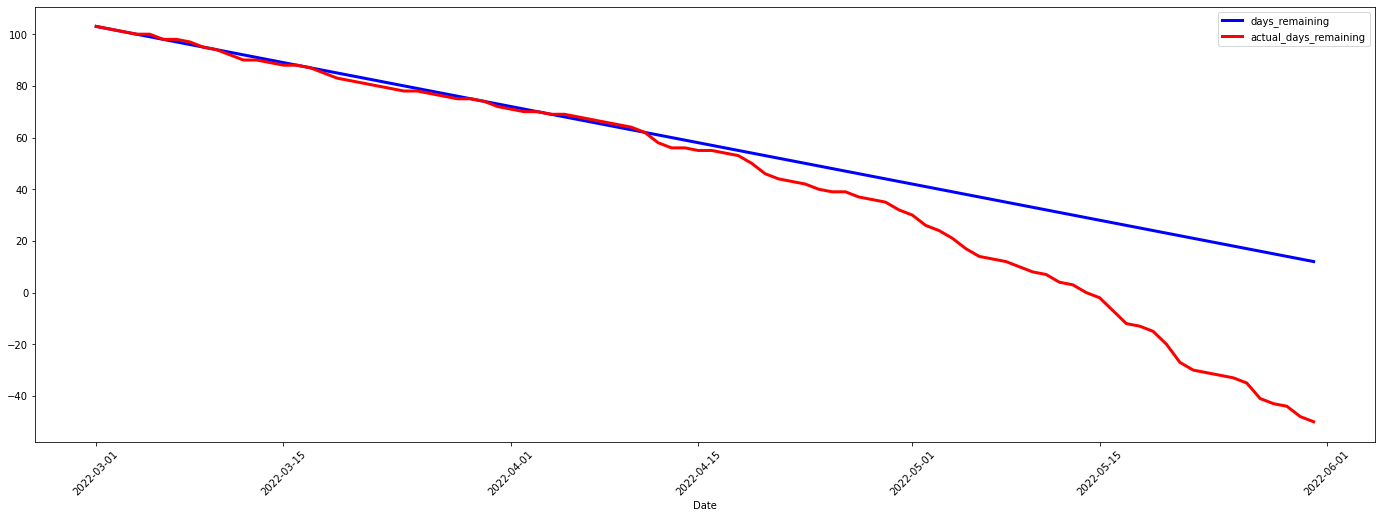

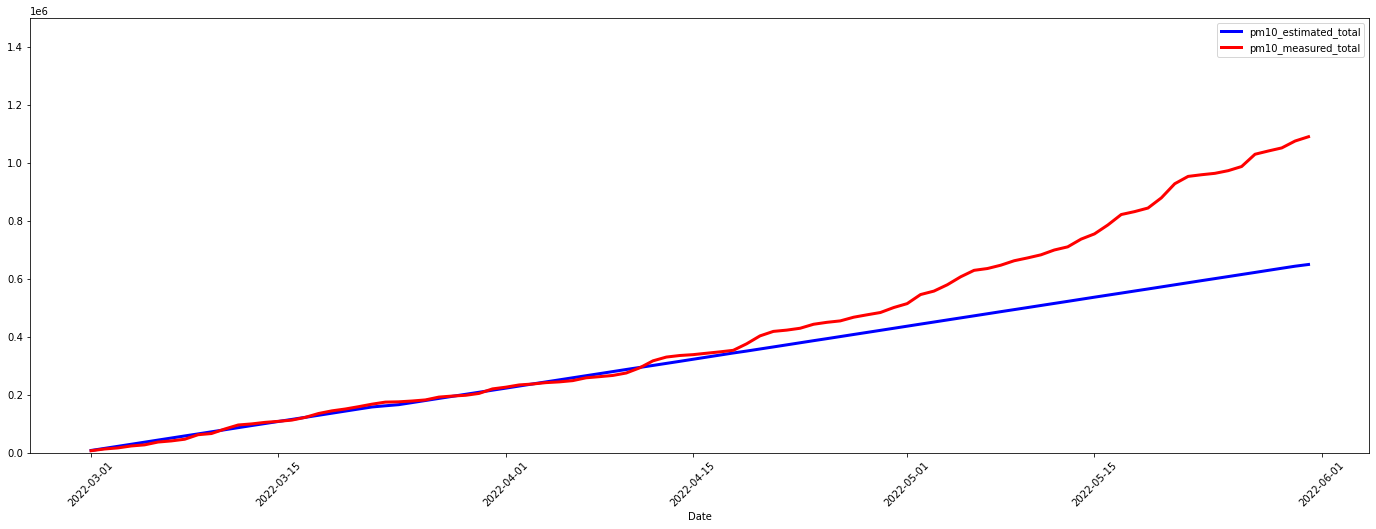

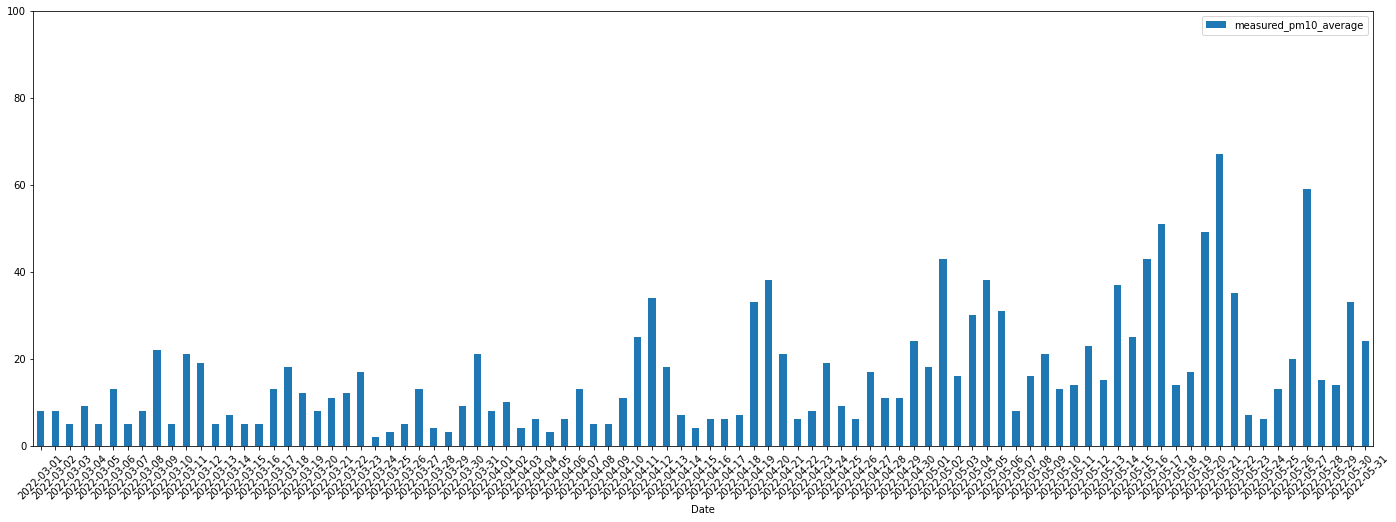

In [39]:
# Do the math
aqdata2=aqdata.groupBy(to_date("timestamp").alias("tdate")).agg(sum("PM10").alias("PM10_SUM"),count("timestamp").alias("num_count"),avg("PM10").alias("PM_10_avg"))

aqdata2=aqdata2.withColumn('estpartPM10',((col('num_count') * lit(rpm10)))).withColumn('estdiff',((col('PM10_SUM') - col('num_count') * lit(rpm10))))
                
aqdata2=aqdata2.orderBy(col("tdate"))
windowSpec=Window.partitionBy().orderBy("tdate")
windowSpec2=Window.partitionBy().orderBy("tdate").rowsBetween(Window.unboundedPreceding,Window.currentRow)
aqdata2=aqdata2.withColumn("days_used",row_number().over(windowSpec))
aqdata2=aqdata2.withColumn("pm10_rolling_total", sum("PM10_SUM").over(windowSpec2)) \
                .withColumn("estpm10_rolling_total", sum("estpartPM10").over(windowSpec2)) \
                .withColumn("estdiff_rolling_total", sum("estdiff").over(windowSpec2))
aqdata2=aqdata2.withColumn("days_remaining", lit(expected_days) - col("days_used"))
aqdata2=aqdata2.withColumn("actual_days_remaining", col("days_remaining") - (col("estdiff_rolling_total")/(col("estpm10_rolling_total")/col("days_used"))))
#aqdata2.show()
aqdata3=aqdata2.select(col("tdate").alias("Date"),col("days_remaining"), \
               col("actual_days_remaining").cast('int'), \
               col("pm10_rolling_total").cast('int').alias("pm10_measured_total"), \
               col("estpm10_rolling_total").cast('int').alias("pm10_estimated_total"), \
               col("PM_10_avg").cast('int').alias("measured_pm10_average")  
               )

act_expdate=aqdata3.filter(aqdata3['actual_days_remaining']==0).select(first(col("Date")).alias("AirfilterExpirationDate")).toPandas()

act_expdate=pd.to_datetime(act_expdate.values[0])

print('Actual date of expiration is predicted to be ' + act_expdate.item().strftime('%Y-%m-%d'))
# plot the graphs
aqdata4=aqdata3.toPandas()

plt1 = aqdata4.plot(figsize=(24,8),x='Date',y=['days_remaining','actual_days_remaining'],color=['blue','red'],linewidth=3.0)
plt2 = aqdata4.plot(figsize=(24,8),x='Date',y=['pm10_estimated_total','pm10_measured_total'],ylim=(0,1500000),color=['blue','red'],linewidth=3.0)
plt3 = aqdata4.plot.bar(figsize=(24,8),x='Date',y='measured_pm10_average',ylim=(0,100))

plt1.tick_params('x', labelrotation=45)
plt2.tick_params('x', labelrotation=45)
plt3.tick_params('x', labelrotation=45)

### Temp P-values

In [103]:
adfuller_result = adfuller(data.Temperature_F.values, autolag='AIC')

print(f'ADF Statistic: {adfuller_result[0]}')

print(f'p-value: {adfuller_result[1]}')

for key, value in adfuller_result[4].items():
    print('Critical Values:')
    print(f' {key}, {value}')

ADF Statistic: -16.41096403213619
p-value: 2.583904609947402e-29
Critical Values:
 1%, -3.430450911334652
Critical Values:
 5%, -2.8615846009620247
Critical Values:
 10%, -2.566793739577894


### Temp & PM10 Skewness

In [102]:
T = data["Temperature_F"]
P10 = data["PM10"]
print("Skewness for data :",skew(T))
print("Skewness for data :",skew(P10))

Skewness for data : 0.7258465348516421
Skewness for data : 4.044903882993682


### Temp & PM10 Kurtosis

In [104]:
kurtosis_scipy = stats.kurtosis(T)
kurtosis_scipyi = stats.kurtosis(P10)
print(kurtosis_scipy)
print(kurtosis_scipyi)

0.3297347278912648
26.59864501943347


In [41]:
aqdata3.show()

+----------+--------------+---------------------+-------------------+--------------------+---------------------+
|Date      |days_remaining|actual_days_remaining|pm10_measured_total|pm10_estimated_total|measured_pm10_average|
+----------+--------------+---------------------+-------------------+--------------------+---------------------+
|2022-03-01|103           |103                  |6270               |7170                |8                    |
|2022-03-02|102           |102                  |12225              |14280               |8                    |
|2022-03-03|101           |101                  |15972              |21400               |5                    |
|2022-03-04|100           |100                  |22655              |28550               |9                    |
|2022-03-05|99            |100                  |26489              |35750               |5                    |
|2022-03-06|98            |98                   |36169              |42950               |13    

Text(0.5, 1.0, 'Accelerometer data')

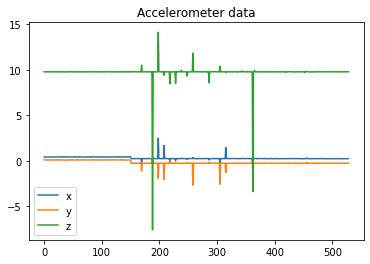

In [75]:
acc_df=df3.toPandas()
acc_df = acc_df.astype({'x': 'float', 'y': 'float', 'z': 'float'})
plt4 = acc_df.plot()
plt4.set_title("Accelerometer")

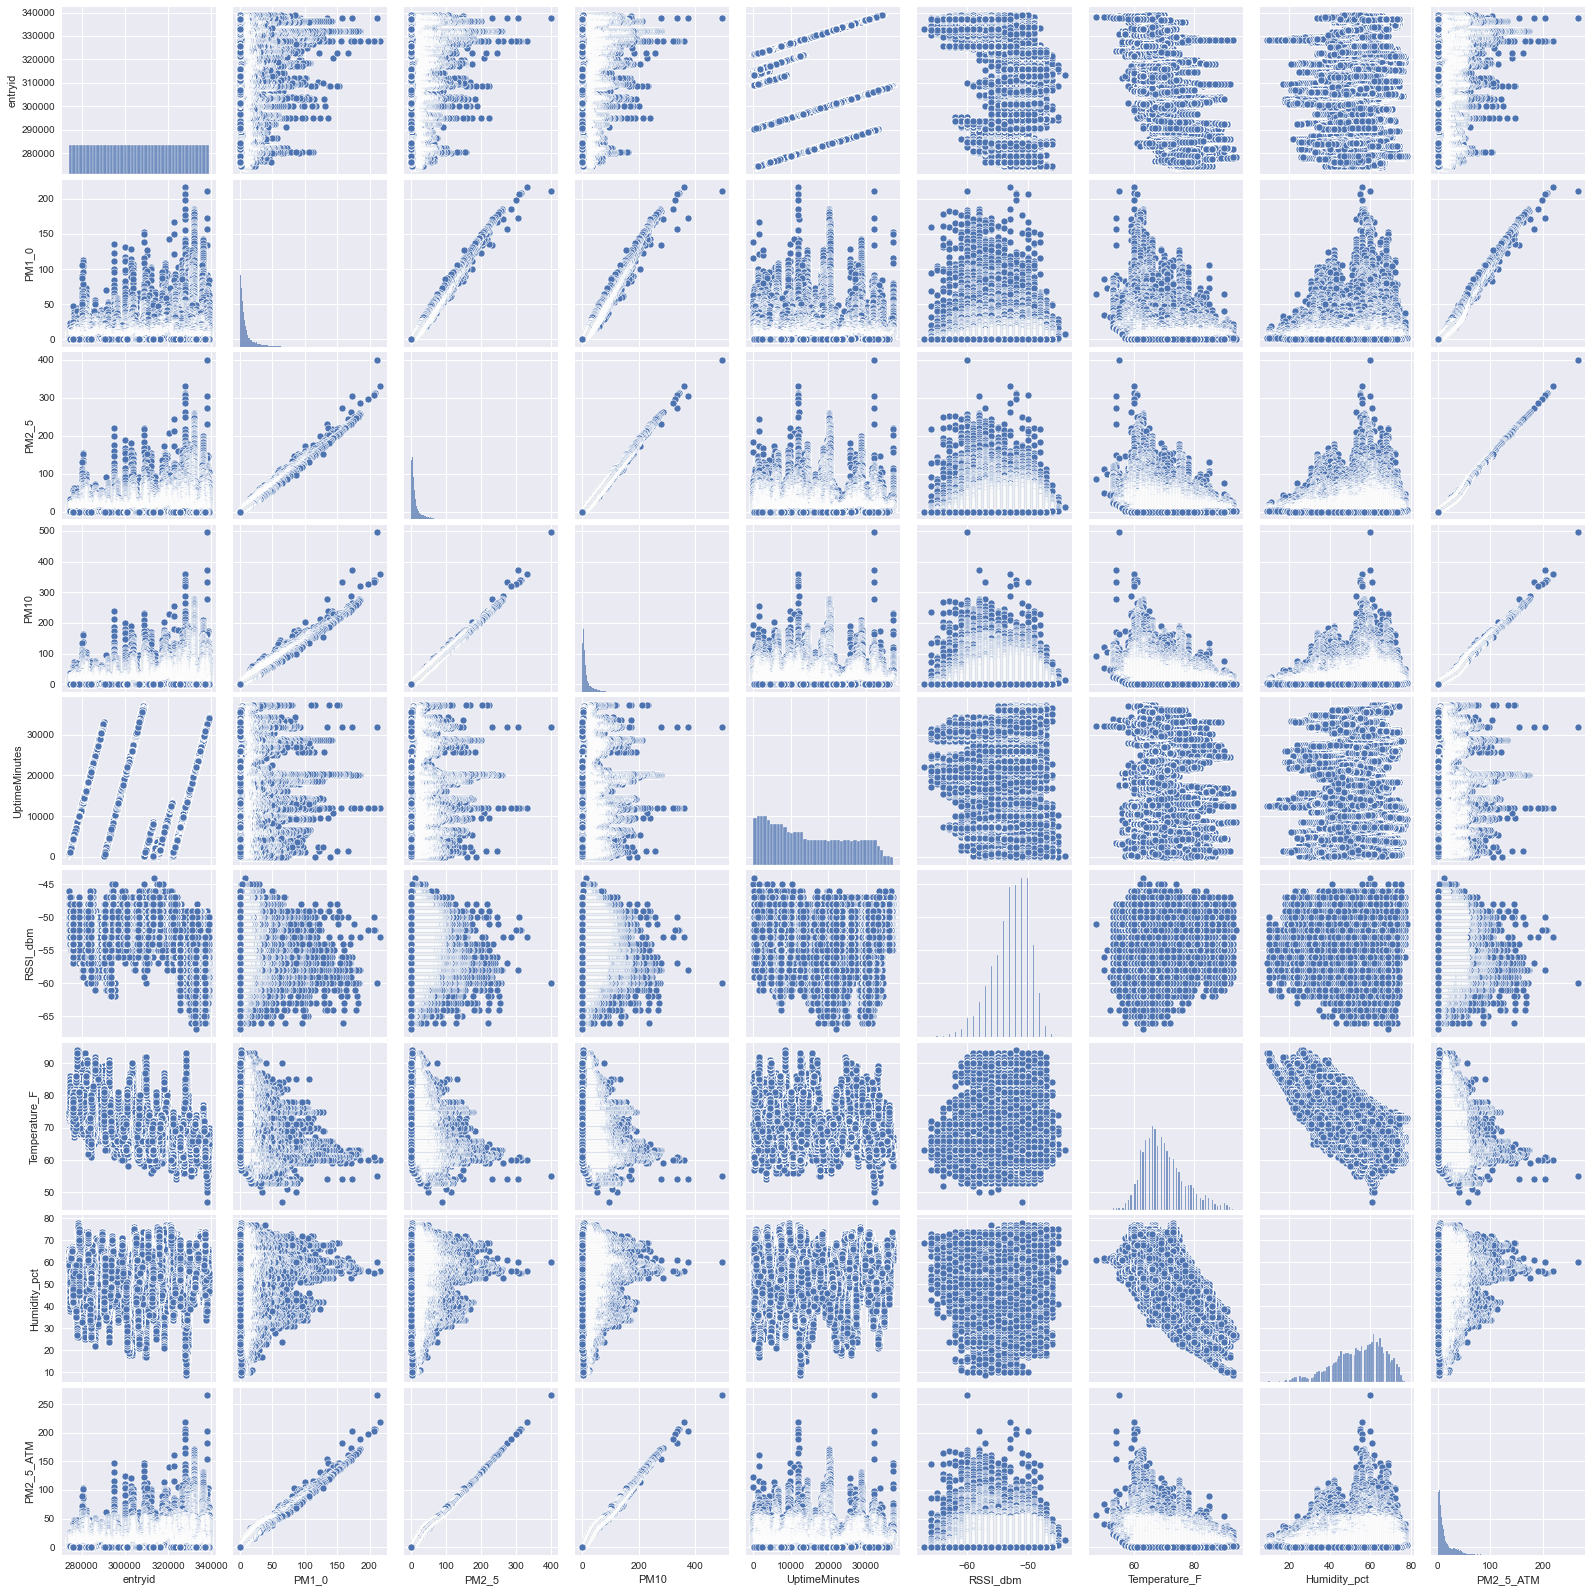

In [97]:
sns.pairplot(data)